+ xlms 자료 구분(text 기준)
+ xlms 자료 읽기(특정범위)
+ xlms data 변환(data fill)
+ xlms data merge
+ bigquery upload

In [1]:
import csv
import xlrd
from pandas import DataFrame
import os
from os import listdir
from datetime import datetime, timedelta

import pandas as pd
import pandas_gbq
from datetime import datetime, timedelta
import time 
import re
from google.cloud import bigquery
from pandas.tseries.offsets import MonthEnd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)


# 접속 정보 : local
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./boxwood-**************.json"
client = bigquery.Client()

### BigQuery 자료현황 확인

In [2]:
sql = """
SELECT FORMAT_DATETIME('%y/%m', CAST(DATE AS DATETIME)) as DATE
, round(sum(OrderAmt)/1000000,0) as OrderAmt
, round(sum(OrderQty)/1000,0) as OrderQty
, round(sum(OrderVol)/1000,0) as OrderVol
, '실적(Actual)' as gubun
FROM `boxwood-**************.SAP_BW.F_Order_Actual`
group by FORMAT_DATETIME('%y/%m', CAST(DATE AS DATETIME))
union all
SELECT FORMAT_DATETIME('%y/%m', CAST(DATE AS DATETIME)) as DATE
, round(sum(OrderAmt_plan)/1000000,0) as OrderAmt
, round(sum(OrderQty_plan)/1000,0) as OrderQty
, round(sum(OrderVol_plan)/1000,0) as OrderVol
, '계획(Plan)' as gubun
FROM `boxwood-**************.SAP_BW.F_Order_Plan`
group by FORMAT_DATETIME('%y/%m', CAST(DATE AS DATETIME))
"""
df_search = client.query(sql).to_dataframe()
df_search= df_search.sort_values(by=['DATE']).reset_index(drop=True)

In [3]:
pd.options.display.float_format = '{:0,.0f}'.format
df0 = pd.pivot_table(df_search, values=['OrderAmt','OrderQty','OrderVol'], columns=['gubun'], index=['DATE'],  aggfunc='sum').fillna(0)

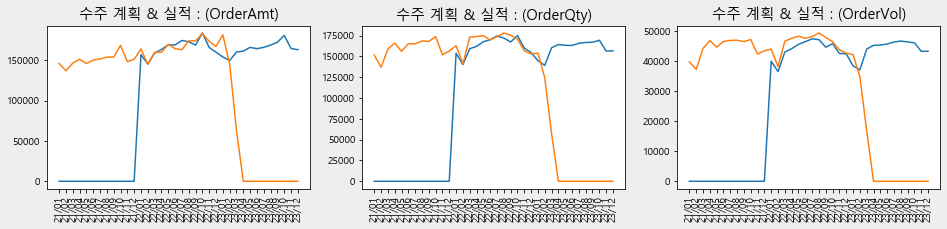

In [4]:
mpl.rc('figure', figsize=(16, 3))
fig = plt.figure( facecolor='#eeeeee')

plt.subplot(1,3,1)
plt.plot(df0.T.iloc[0:2].T)
plt.xticks(rotation=90)
plt.title('{} : ({})'.format('수주 계획 & 실적', 'OrderAmt'),fontsize='x-large')

plt.subplot(1,3,2)
plt.plot(df0.T.iloc[2:4].T)
plt.xticks(rotation=90)
plt.title('{} : ({})'.format('수주 계획 & 실적', 'OrderQty'),fontsize='x-large')

plt.subplot(1,3,3)
plt.plot(df0.T.iloc[4:].T)
plt.xticks(rotation=90)
plt.title('{} : ({})'.format('수주 계획 & 실적', 'OrderVol'),fontsize='x-large')

plt.show()

In [5]:
df0.tail(12)

OrderAmt            OrderQty            OrderVol           
gubun 계획(Plan) 실적(Actual) 계획(Plan) 실적(Actual) 계획(Plan) 실적(Actual)
DATE                                                             
23/01  154,299    181,778  144,972    154,029   38,436     42,169
23/02  149,911    145,818  139,301    124,463   37,096     34,880
23/03  160,428     63,367  160,413     57,393   43,980     16,839
23/04  161,556          0  164,352          0   45,251          0
23/05  166,195          0  163,419          0   45,327          0
23/06  164,557          0  163,227          0   45,701          0
23/07  166,252          0  165,910          0   46,356          0
23/08  169,003          0  166,838          0   46,678          0
23/09  172,508          0  167,040          0   46,372          0
23/10  181,112          0  169,503          0   46,094          0
23/11  164,775          0  156,511          0   43,269          0
23/12  163,300          0  156,782          0   43,282          0

### xlsm 자료 변환

In [6]:
# 경로 설정
directory_name = "./DATA"

# 파일명 가져오기
file_dir = listdir(directory_name)

In [7]:
file_dir

['ZPB_SD_Q013_F_Order_Actual_20230314-20230323.xlsx']

In [8]:
def read_data(f_name):
    df_temp = pd.read_excel(directory_name+'/' + f_name, sheet_name=0)
    col_nm ={
            "Unnamed: 5": "PrdName",
            }
    df_temp = df_temp.rename(columns=col_nm, errors="raise")
    try:
        df_temp['달력연도/월'] = df_temp['달력연도/월'].apply(str)
        df_temp['DATE'] = pd.to_datetime(df_temp['달력연도/월'], format='%Y.%m') + MonthEnd(0)
    except: 
        df_temp['DATE'] = pd.to_datetime(df_temp['달력(일)'])
    df_temp['자재'] = df_temp['자재'].apply(str)
    return df_temp


def rename_table_actual(dataset):
    col_nm ={
            "DATE"                  : "Date",
            "EIS 표준계층구조 1레벨": "EIS1",
            "EIS 표준계층구조 2레벨": "EIS2",
            "EIS 표준계층구조 3레벨": "EIS3",
            "자재"                  : "PrdCode",
            "고객계층구조레벨 1(N"  : "Chnl1",
            "고객계층구조레벨 2(N"  : "Chnl2",
            "고객계층구조레벨 3(N"  : "Chnl3",
            "수주수량"              : "OrderQty",
            "수주환산용량"          : "OrderVol",
            "수주금액"              : "OrderAmt",
            }
    df_t = dataset.rename(columns=col_nm, errors="raise")
    df_t['OrderAmt'] = df_t['OrderAmt'].astype(float)
    df_t['OrderQty'] = df_t['OrderQty'].astype(float)
    df_t['OrderVol'] = df_t['OrderVol'].astype(float)
    df_t = df_t[["EIS1", "EIS2", "EIS3", "PrdCode", "PrdName", "Date", "Chnl1", "Chnl2", "Chnl3", 
                 "OrderAmt", "OrderQty", "OrderVol" ]]
    return df_t




def rename_table_plan(dataset):
    col_nm ={
            "DATE"                  : "Date",
            "EIS 표준계층구조 1레벨": "EIS1",
            "EIS 표준계층구조 2레벨": "EIS2",
            "EIS 표준계층구조 3레벨": "EIS3",
            "자재"                  : "PrdCode",
            "고객계층구조레벨 1(N"  : "Chnl1",
            "고객계층구조레벨 2(N"  : "Chnl2",
            "고객계층구조레벨 3(N"  : "Chnl3",
            "판매계획수량"          : "OrderQty_plan",
            "판매계획수주환산용량"  : "OrderVol_plan",
            "판매계획금액"          : "OrderAmt_plan",
            }
    df_t = dataset.rename(columns=col_nm, errors="raise")
    df_t['OrderAmt_plan'] = df_t['OrderAmt_plan'].astype(float)
    df_t['OrderQty_plan'] = df_t['OrderQty_plan'].astype(float)
    df_t['OrderVol_plan'] = df_t['OrderVol_plan'].astype(float)
    df_t = df_t[["EIS1", "EIS2", "EIS3", "PrdCode", "PrdName", "Date", "Chnl1", "Chnl2", "Chnl3", 
                 "OrderAmt_plan", "OrderQty_plan", "OrderVol_plan" ]]
    return df_t

In [9]:
# test
df_temp = read_data(file_dir[0])

In [10]:
df_temp.DATE.unique()

array(['2023-03-14T00:00:00.000000000', '2023-03-15T00:00:00.000000000',
       '2023-03-16T00:00:00.000000000', '2023-03-17T00:00:00.000000000',
       '2023-03-18T00:00:00.000000000', '2023-03-19T00:00:00.000000000',
       '2023-03-20T00:00:00.000000000', '2023-03-21T00:00:00.000000000',
       '2023-03-22T00:00:00.000000000', '2023-03-23T00:00:00.000000000'],
      dtype='datetime64[ns]')

### BigQuery 테이블 확인

In [11]:
#########
# 자료1 : rawdata 저장 목적
###
sql = """
    SELECT max(date)
    FROM `boxwood-**************.SAP_BW.F_Order_Actual`
    limit 2
    """
df_format = client.query(sql).to_dataframe()

In [12]:
df_format

,f0_
0,2023-03-01 00:00:00+00:00


In [11]:
#########
# 자료1 : rawdata 저장 목적
###
sql = """
    SELECT FORMAT_DATETIME('%y/%m', CAST(DATE AS DATETIME)) as DATE
    , min(FORMAT_DATETIME('%y/%m/%d', CAST(DATE AS DATETIME))) as DATE_min
    , max(FORMAT_DATETIME('%y/%m/%d', CAST(DATE AS DATETIME))) as DATE_max
    FROM `boxwood-**************.SAP_BW.F_Order_Actual`
    where CAST(DATE AS DATETIME) between DATE_SUB(current_date(), INTERVAL 3 month ) and DATE_SUB(current_date(), INTERVAL 0 month)
    group by FORMAT_DATETIME('%y/%m', CAST(DATE AS DATETIME))
    """
df_search = client.query(sql).to_dataframe()

In [12]:
df_search

,DATE,DATE_min,DATE_max
0,23/01,23/01/01,23/01/31
1,22/12,22/12/24,22/12/31
2,23/03,23/03/01,23/03/13
3,23/02,23/02/01,23/02/28


### BigQuery에 자료 저장

In [13]:
rename_table_actual(df_temp).tail(2)

,EIS1,EIS2,EIS3,PrdCode,PrdName,Date,Chnl1,Chnl2,Chnl3,OrderAmt,OrderQty,OrderVol
39104,기타 제품군,상하농원,동물복지란,204505,코스트코_상하농원 순갈색 유정란30구,2023-03-23,KA,Wholesale,코스트코,"6,494,400",720,"1,123"
39105,기타 제품군,원료기타,전탈지대용량,106480,탈지분유[용도] 20kg*1,2023-03-23,특수채널,특수처영업,특수대리점,"366,000",2,40


In [14]:
df_temp.DATE.min()

Timestamp('2023-03-14 00:00:00')

In [15]:
rename_table_actual(df_temp).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39106 entries, 0 to 39105
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   EIS1      39106 non-null  object        
 1   EIS2      39106 non-null  object        
 2   EIS3      39106 non-null  object        
 3   PrdCode   39106 non-null  object        
 4   PrdName   39106 non-null  object        
 5   Date      39106 non-null  datetime64[ns]
 6   Chnl1     39106 non-null  object        
 7   Chnl2     39106 non-null  object        
 8   Chnl3     39106 non-null  object        
 9   OrderAmt  39106 non-null  float64       
 10  OrderQty  39106 non-null  float64       
 11  OrderVol  39106 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(8)
memory usage: 3.6+ MB


In [16]:
# file_dir

In [17]:
client = bigquery.Client()
project = 'boxwood-**************'
dataset_id = 'SAP_BW'
table_id = 'F_Order_Actual'
table_name = dataset_id +'.' +table_id

In [18]:
pandas_gbq.to_gbq(rename_table_actual(df_temp), table_name, project_id=project, if_exists = 'append' )

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.33it/s]


In [84]:
%%time
for t_ in file_dir:
    pandas_gbq.to_gbq(rename_table_actual(read_data(t_)), table_name, project_id=project, if_exists = 'append' )

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Wall time: 8min 31s


In [65]:
project_id = project

sql = """
SELECT FORMAT_DATETIME('%y/%m', CAST(DATE AS DATETIME)) as DATE, count(*) as CNT
FROM `boxwood-**************.SAP_BW.F_Order_Actual`
group by FORMAT_DATETIME('%y/%m', CAST(DATE AS DATETIME))
"""
df1 = pandas_gbq.read_gbq(sql, project_id=project_id)
df1 = df1.sort_values(by=['DATE']).reset_index(drop=True)

Downloading: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 74.33rows/s]


In [22]:
fig = plt.figure( facecolor='#eeeeee')
plt.bar(df1.DATE, df1.CNT)
plt.xticks(rotation=90)
plt.title('{} : ({})'.format('수주 실적', 'F_Order_Actual'),fontsize='x-large')
plt.show()

NameError: name 'df1' is not defined

<Figure size 432x288 with 0 Axes>

In [19]:

#########
# 자료1 : rawdata 저장 목적
###
sql = """
    SELECT FORMAT_DATETIME('%y/%m', CAST(DATE AS DATETIME)) as DATE
    , count(*) as data_count
    , sum(OrderAmt)/1000 as OrderAmt
    , min(FORMAT_DATETIME('%y/%m/%d', CAST(DATE AS DATETIME))) as DATE_min
    , max(FORMAT_DATETIME('%y/%m/%d', CAST(DATE AS DATETIME))) as DATE_max
    FROM `boxwood-**************.SAP_BW.F_Order_Actual`
    where CAST(DATE AS DATETIME) between DATE_SUB(current_date(), INTERVAL 13 month ) and DATE_SUB(current_date(), INTERVAL 0 month)
    group by FORMAT_DATETIME('%y/%m', CAST(DATE AS DATETIME))
    """
df_search = client.query(sql).to_dataframe()

In [20]:
df_search = df_search.sort_values(by=['DATE']).reset_index(drop=True)

In [21]:
df_search

,DATE,data_count,OrderAmt,DATE_min,DATE_max
0,22/02,20179,"34,910,777",22/02/24,22/02/28
1,22/03,121949,"160,032,267",22/03/01,22/03/31
2,22/04,120948,"160,133,165",22/04/01,22/04/30
3,22/05,124410,"169,931,523",22/05/01,22/05/31
4,22/06,119661,"164,593,917",22/06/01,22/06/30
5,22/07,122908,"163,281,807",22/07/01,22/07/31
6,22/08,127190,"174,236,702",22/08/01,22/08/31
7,22/09,116163,"174,363,173",22/09/01,22/09/30
8,22/10,124246,"183,251,579",22/10/01,22/10/31
9,22/11,124580,"173,715,512",22/11/01,22/11/30
